In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
input_range = torch.linspace(-1, 1, steps=100).view(1, -1).to(device)
input_range = input_range.requires_grad_(True)

# Reference function
def target_function(x):
    return torch.sin(10 * x)

true_output = target_function(input_range).to(device)


In [35]:
# Xavier initialization function
def xavier_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

# Neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_dim),
        )
        self.network.apply(xavier_init)

    def forward(self, x):
        return self.network(x)

In [36]:
# Initialize model
hidden_units = 100
model = NeuralNetwork(1, hidden_units, 1).to(device)

In [37]:
# Optimizer and loss function
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(input_range.T).T
    loss = criterion(predictions, true_output)
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % 50 == 1 or epoch + 1 == epochs:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item():.5f}")

Epoch: 1, Loss: 0.46338
Epoch: 51, Loss: 0.46064
Epoch: 101, Loss: 0.46050
Epoch: 151, Loss: 0.46015
Epoch: 201, Loss: 0.45299
Epoch: 251, Loss: 0.45058
Epoch: 301, Loss: 0.45029
Epoch: 351, Loss: 0.45012
Epoch: 401, Loss: 0.44962
Epoch: 451, Loss: 0.31596
Epoch: 501, Loss: 0.08906
Epoch: 551, Loss: 0.00213
Epoch: 601, Loss: 0.00022
Epoch: 651, Loss: 0.00024
Epoch: 701, Loss: 0.00008
Epoch: 751, Loss: 0.00007
Epoch: 801, Loss: 0.00006
Epoch: 851, Loss: 0.00089
Epoch: 901, Loss: 0.00005
Epoch: 951, Loss: 0.00181
Epoch: 1001, Loss: 0.00004
Epoch: 1051, Loss: 0.00003
Epoch: 1101, Loss: 0.00003
Epoch: 1151, Loss: 0.00090
Epoch: 1201, Loss: 0.00002
Epoch: 1251, Loss: 0.00002
Epoch: 1301, Loss: 0.00007
Epoch: 1351, Loss: 0.00002
Epoch: 1401, Loss: 0.00002
Epoch: 1451, Loss: 0.00001
Epoch: 1501, Loss: 0.00005
Epoch: 1551, Loss: 0.00001
Epoch: 1601, Loss: 0.00001
Epoch: 1651, Loss: 0.00005
Epoch: 1701, Loss: 0.00001
Epoch: 1751, Loss: 0.00001
Epoch: 1801, Loss: 0.00001
Epoch: 1851, Loss: 0.000

In [38]:
# Predictions after training
model.eval()
with torch.no_grad():
    predicted_output = model(input_range.T).T

In [39]:
error = torch.norm(true_output - predicted_output, p=2)
print(f"Error: {error.item()}")

Error: 0.01338624581694603


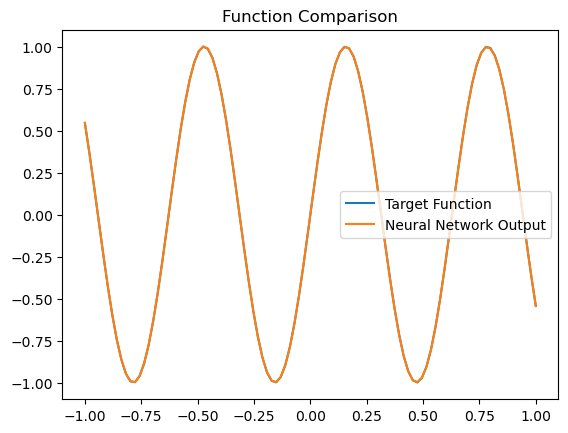

In [40]:
# Plot results
plt.plot(input_range.cpu().detach().numpy().flatten(), true_output.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_range.cpu().detach().numpy().flatten(), predicted_output.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()

In [41]:
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    Computes the derivative of a given tensor 'dy' with respect to another tensor 'x',
    up to a specified order.

    Args:
        dy (torch.Tensor): The tensor whose derivative is to be computed.
        x (torch.Tensor): The tensor with respect to which the derivative is to be computed.
        order (int, optional): The order of the derivative to compute. Defaults to 1, which
                               means a first-order derivative. Higher orders result in higher-order
                               derivatives.

    Returns:
        torch.Tensor: The computed derivative of 'dy' with respect to 'x', of the specified order.
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy  

In [42]:
predicted_output_grad  = derivative(model(input_range.T).T, input_range, 1)[0]
target_output_grad = derivative(target_function(input_range), input_range, 1)[0]

In [43]:
error_1 = torch.norm(target_output_grad - predicted_output_grad, p=2)
print(f"Error: {error_1.item()}")

Error: 0.7006418704986572


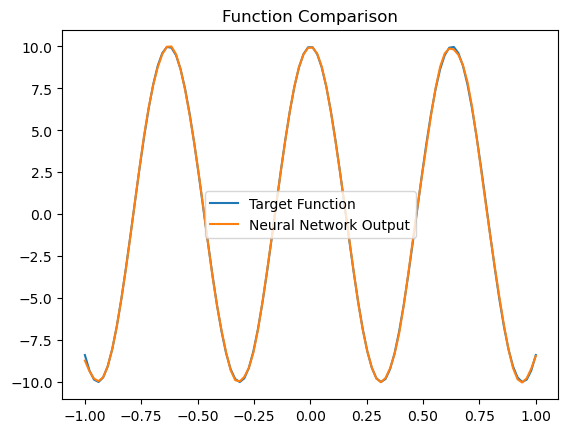

In [44]:
# Plot results
plt.plot(input_range.cpu().detach().numpy().flatten(), target_output_grad.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_range.cpu().detach().numpy().flatten(), predicted_output_grad.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()

In [45]:
predicted_output_grad_2  = derivative(model(input_range.T).T, input_range, 2)[0]
target_output_grad_2 = derivative(target_function(input_range), input_range, 2)[0]

In [46]:
error_2 = torch.norm(target_output_grad_2 - predicted_output_grad_2, p=2)
print(f"Error: {error_2.item()}")

Error: 40.9039421081543


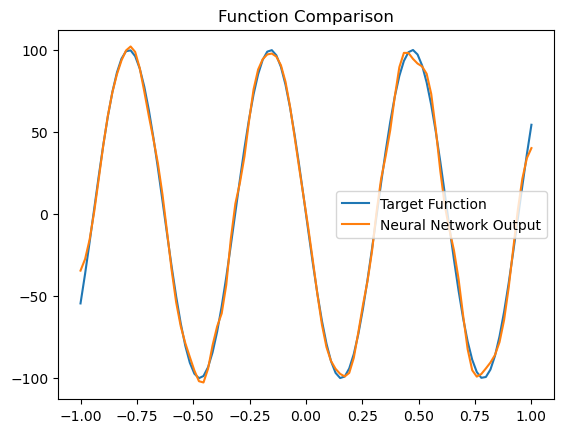

In [47]:
# Plot results
plt.plot(input_range.cpu().detach().numpy().flatten(), target_output_grad_2.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_range.cpu().detach().numpy().flatten(), predicted_output_grad_2.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()